### Installing required packages

In [ ]:
pip install -r requirements.txt

### File Merging
This cell merges the 13 csv files into a single csv

In [5]:
import pandas as pd
import glob

# define path with raw csv files
folder_path = 'raw csv/'

# Get a list of all CSV files in the specified folder
all_csv_files = glob.glob(folder_path + "*.csv")

# Initialize an empty list to store individual DataFrames
li = []

# Loop through each CSV file, read it, and append to the list
for filename in all_csv_files:
    try:
        df_chunk = pd.read_csv(filename, low_memory=False)
        li.append(df_chunk)
        print(f"Successfully loaded {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Concatenate all DataFrames in the list into a single DataFrame
if li:
    merged_df = pd.concat(li, axis=0, ignore_index=True)
    print(f"\nSuccessfully merged {len(li)} CSV files. Total rows: {merged_df.shape[0]}, Total columns: {merged_df.shape[1]}")

    # Save the merged DataFrame to a new CSV file in Google Drive
    output_filename = 'merged_twitter_trolls.csv'
    merged_df.to_csv(output_filename, index=False)
    print(f"Merged data saved to '{output_filename}'")
else:
    print("No CSV files found or loaded successfully. Please check the folder_path and file contents.")


Successfully loaded raw csv/IRAhandle_tweets_4.csv
Successfully loaded raw csv/IRAhandle_tweets_5.csv
Successfully loaded raw csv/IRAhandle_tweets_7.csv
Successfully loaded raw csv/IRAhandle_tweets_6.csv
Successfully loaded raw csv/IRAhandle_tweets_2.csv
Successfully loaded raw csv/IRAhandle_tweets_3.csv
Successfully loaded raw csv/IRAhandle_tweets_1.csv
Successfully loaded raw csv/IRAhandle_tweets_12.csv
Successfully loaded raw csv/IRAhandle_tweets_13.csv
Successfully loaded raw csv/IRAhandle_tweets_11.csv
Successfully loaded raw csv/IRAhandle_tweets_10.csv
Successfully loaded raw csv/IRAhandle_tweets_8.csv
Successfully loaded raw csv/IRAhandle_tweets_9.csv

Successfully merged 13 CSV files. Total rows: 2946207, Total columns: 21
Merged data saved to 'merged_twitter_trolls.csv'


### Conversion of the csv file to parquet
Convert csv to parquet to facilitate the processing of data

In [4]:
# Import necessary libraries
import re

# Define the path to your original CSV
csv_file_path = 'merged_twitter_trolls.csv'
output_parquet_file = 'russian_trolls.parquet'

try:
    # 1. Read the CSV file
    print("Reading CSV file...")
    df = pd.read_csv(csv_file_path, low_memory=False)
    initial_rows = df.shape[0]
    print(f"Dataset loaded. Initial rows: {initial_rows}")


    # 2. Save to Spark-Compatible Parquet
    print(f"Saving to {output_parquet_file}...")
    df.to_parquet(
        output_parquet_file,
        engine='pyarrow',
        compression='snappy',
        index=False,
        # These two options are key for Databricks/Spark compatibility
        allow_truncated_timestamps=True,
        version='1.0'
    )
    print("File saved")

except FileNotFoundError:
    print(f"Error: File not found at {csv_file_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Reading CSV file...
Dataset loaded. Initial rows: 2946207
Saving to russian_trolls.parquet...
File saved


### Load parquet as a pandas dataframe

In [2]:
file_path = 'russian_trolls.parquet'

try:
    print("Loading dataset...")
    df = pd.read_parquet(file_path)

    # Ensure date is datetime format
    df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')

    print("Dataset loaded.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

Loading dataset...
Dataset loaded.
Shape: (2946207, 21)


### Data verification
This cell shows the first 5 rows of the dataset

In [14]:
#
# ---------------------------------------------------------------------------------
# EDA Script for the FULL, PROCESSED Russian Troll Tweets Dataset
# ---------------------------------------------------------------------------------
#

#
# --- 1. Import Necessary Libraries ---
#
# (This section remains exactly the same)
#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter


print("\n--- Initial Data Inspection ---")
print("Shape of the dataset (rows, columns):", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nColumn data types and non-null values:")
# Note how the dtypes are already optimized!
df.info()





--- Initial Data Inspection ---
Shape of the dataset (rows, columns): (2946207, 21)

First 5 rows of the dataset:
  external_author_id        author  \
0         2495567768  DAILYSANFRAN   
1         2495567768  DAILYSANFRAN   
2         2495567768  DAILYSANFRAN   
3         2495567768  DAILYSANFRAN   
4         2495567768  DAILYSANFRAN   

                                             content         region language  \
0  Police: Airline pilot found passed out in cock...  United States  English   
1  Dashcam video shows man launching himself onto...  United States  English   
2  Man Arrested For Setting Fire To South SF Medi...  United States  English   
3  Practical tips to achieving your New Year's re...  United States  English   
4  Couple disappears during trip to Big Sur https...  United States  English   

         publish_date  harvested_date  following  followers  updates  ...  \
0 2017-01-02 14:39:00  1/2/2017 14:39       4577      16782    34960  ...   
1 2017-01-02 15:39:00

### Cleans Analysis
This cell cleans the data by converting date columns to the correct format and checks for missing values

In [3]:
# 1. DateTime Conversion
# Ensuring dates are actual datetime objects for temporal analysis
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df['harvested_date'] = pd.to_datetime(df['harvested_date'], errors='coerce')

# 2. Missing Values Check
missing = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing[missing > 0])

# 3. Duplicate Check (based on tweet_id)
duplicates = df.duplicated(subset=['tweet_id']).sum()
print(f"\nDuplicate Tweet IDs found: {duplicates}")

# 4. Date Range Check
print(f"\nDate Range: {df['publish_date'].min()} to {df['publish_date'].max()}")


Missing Values per Column:
content             1
region           8818
post_type     1648625
tco1_step1     845971
tco2_step1    2235090
tco3_step1    2931207
dtype: int64

Duplicate Tweet IDs found: 1392

Date Range: 2012-02-02 00:35:00 to 2018-05-30 21:01:00


### Temporal Analysis
This cell plots the distribution of tweets over time.

--- PART 1: TEMPORAL ANALYSIS ---



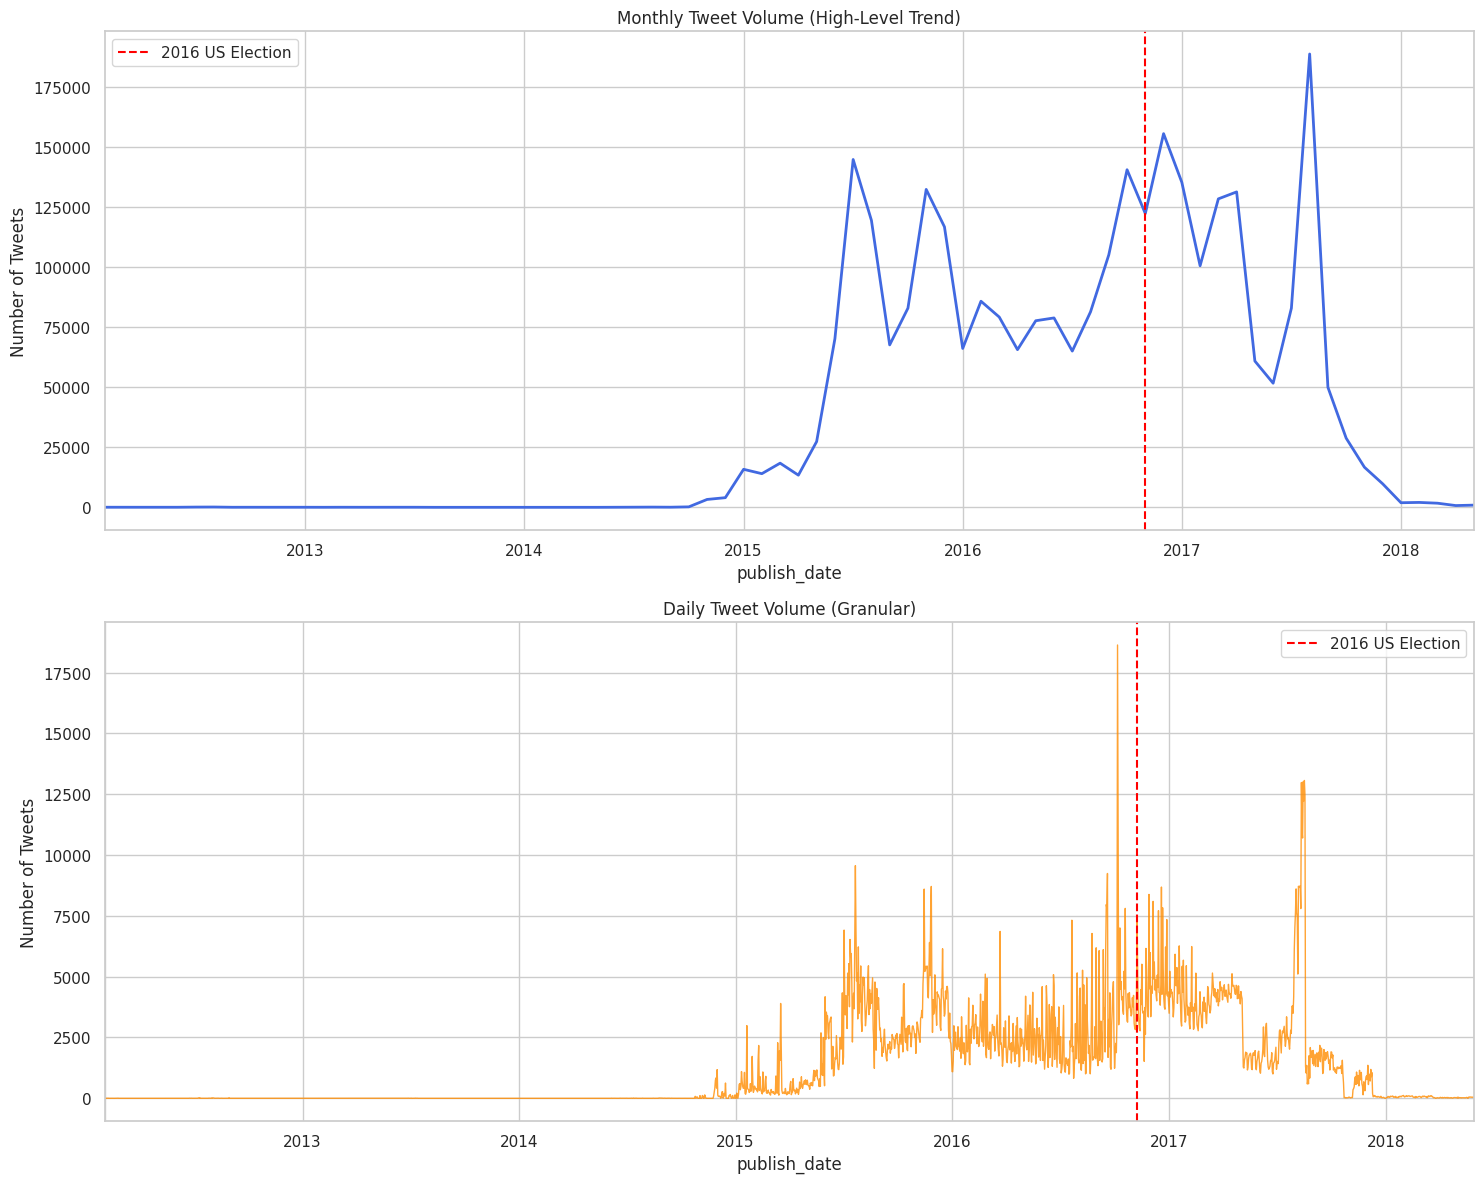

In [ ]:
# Set index to publish_date for resampling
time_df = df.set_index('publish_date').sort_index()

# Resample by Month ('ME' is month-end) and Day
monthly_counts = time_df.resample('ME').size()
daily_counts = time_df.resample('D').size()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Monthly Trend
monthly_counts.plot(ax=ax[0], color='royalblue', linewidth=2)
ax[0].set_title('Monthly Tweet Volume (High-Level Trend)')
ax[0].set_ylabel('Number of Tweets')
# Highlight 2016 Election (common in this dataset's analysis)
election_date = '2016-11-08'
ax[0].axvline(pd.to_datetime(election_date), color='red', linestyle='--', label='2016 US Election')
ax[0].legend()

# Daily Trend (Granular)
daily_counts.plot(ax=ax[1], color='darkorange', linewidth=1, alpha=0.8)
ax[1].set_title('Daily Tweet Volume (Granular)')
ax[1].set_ylabel('Number of Tweets')

# Highlight 2016 Election (common in this dataset's analysis)
election_date = '2016-11-08'
ax[1].axvline(pd.to_datetime(election_date), color='red', linestyle='--', label='2016 US Election')
ax[1].legend()

plt.tight_layout()
plt.show()

### Category Analysis
This cell analyzes and visualizes the distribution of different account categories in the dataset.

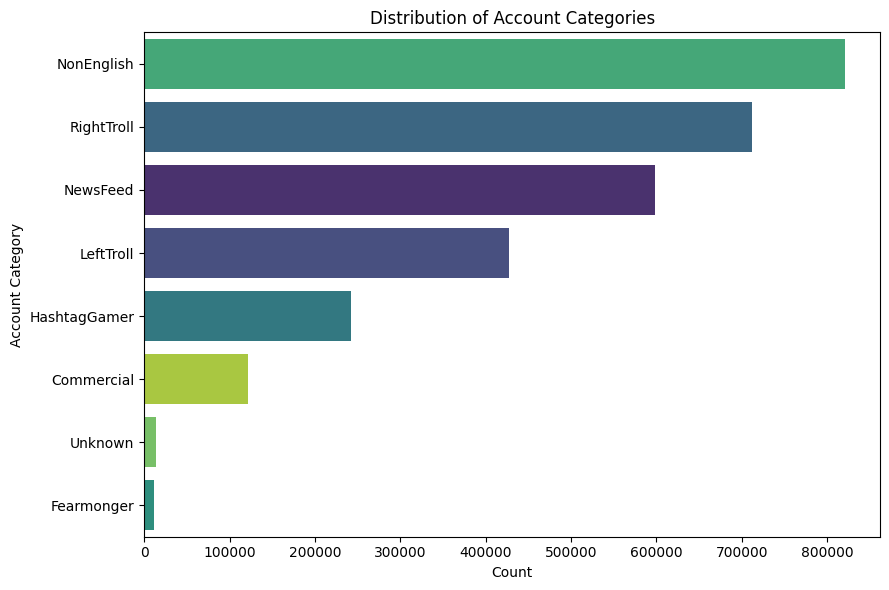

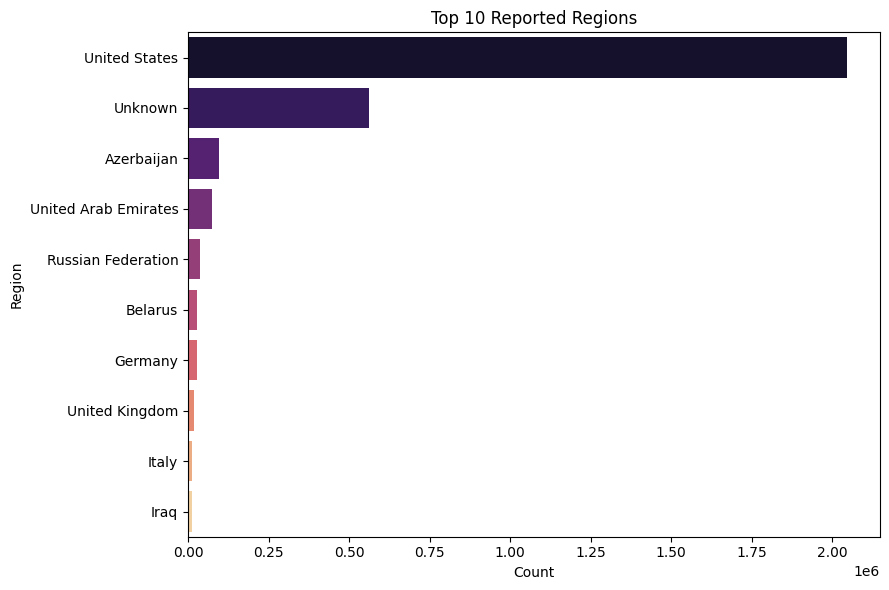

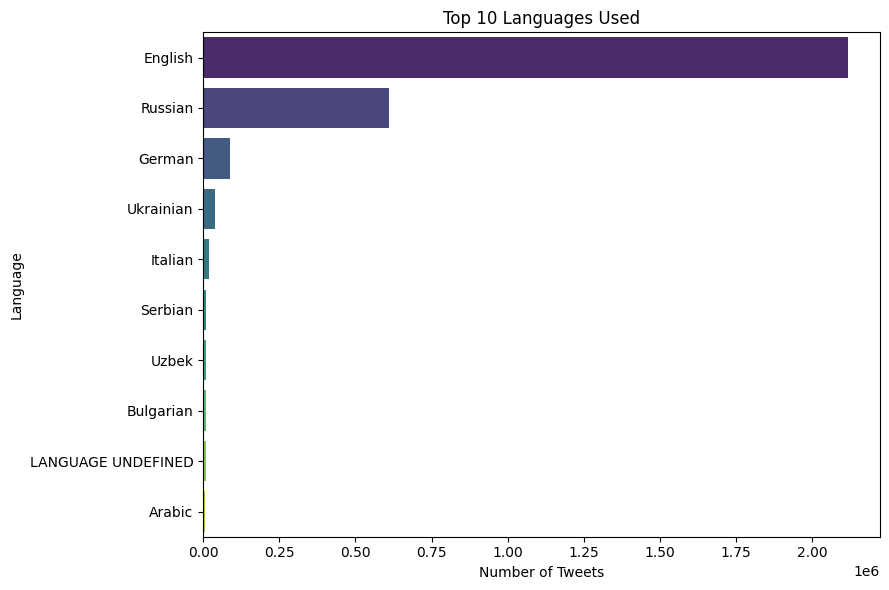

In [ ]:
# 1. Account Category Distribution
plt.figure(figsize=(9, 6))
sns.countplot(y='account_category', data=df, order=df['account_category'].value_counts().index,
              palette='viridis', hue='account_category', legend=False)
plt.title('Distribution of Account Categories')
plt.xlabel('Count')
plt.ylabel('Account Category')
plt.tight_layout()
plt.show()

# 2. Region Distribution
plt.figure(figsize=(9, 6))
top_regions = df['region'].value_counts().head(10)
sns.barplot(x=top_regions.values, y=top_regions.index, palette='magma', hue=top_regions.index, legend=False)
plt.title('Top 10 Reported Regions')
plt.xlabel('Count')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

# 3. Top Languages
plt.figure(figsize=(9, 6))
top_languages = df['language'].value_counts().nlargest(10)
sns.barplot(y=top_languages.index.astype(str), x=top_languages.values, palette='viridis', hue=top_languages.index.astype(str), legend=False)
plt.title('Top 10 Languages Used')
plt.xlabel('Number of Tweets')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

### Hashtag Analysis
This cell identifies and visualizes the most frequently used hashtags in the dataset.

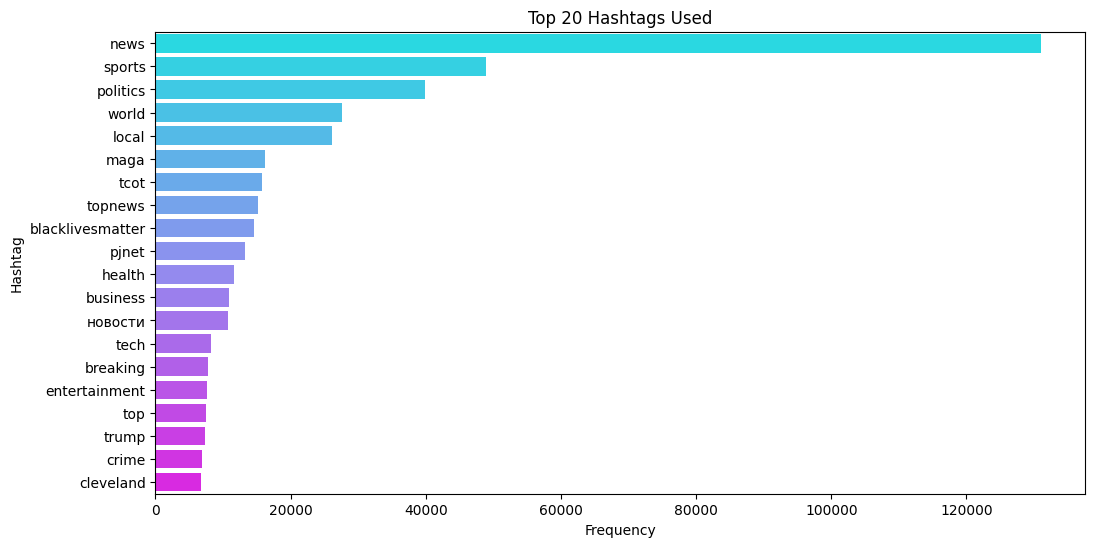

In [15]:
# Simplified function dedicated to hashtags
def get_top_hashtags(text_series, top_n=20):
    all_hashtags = []
    for text in text_series.dropna():
        # Find all words that start with '#'
        # \w+ matches alphanumeric characters including underscores
        tags = re.findall(r"#(\w+)", str(text))

        # Convert to lowercase to ensure #News and #news are counted together
        tags = [tag.lower() for tag in tags]

        all_hashtags.extend(tags)

    return Counter(all_hashtags).most_common(top_n)

# 1. Calculate Top Hashtags
top_hashtags_list = get_top_hashtags(df['content'])
hashtags_df = pd.DataFrame(top_hashtags_list, columns=['Hashtag', 'Count'])

# 2. Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Hashtag', data=hashtags_df, palette='cool', hue='Hashtag', legend=False)
plt.title('Top 20 Hashtags Used')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

### Activity Patterns by Day and Hour

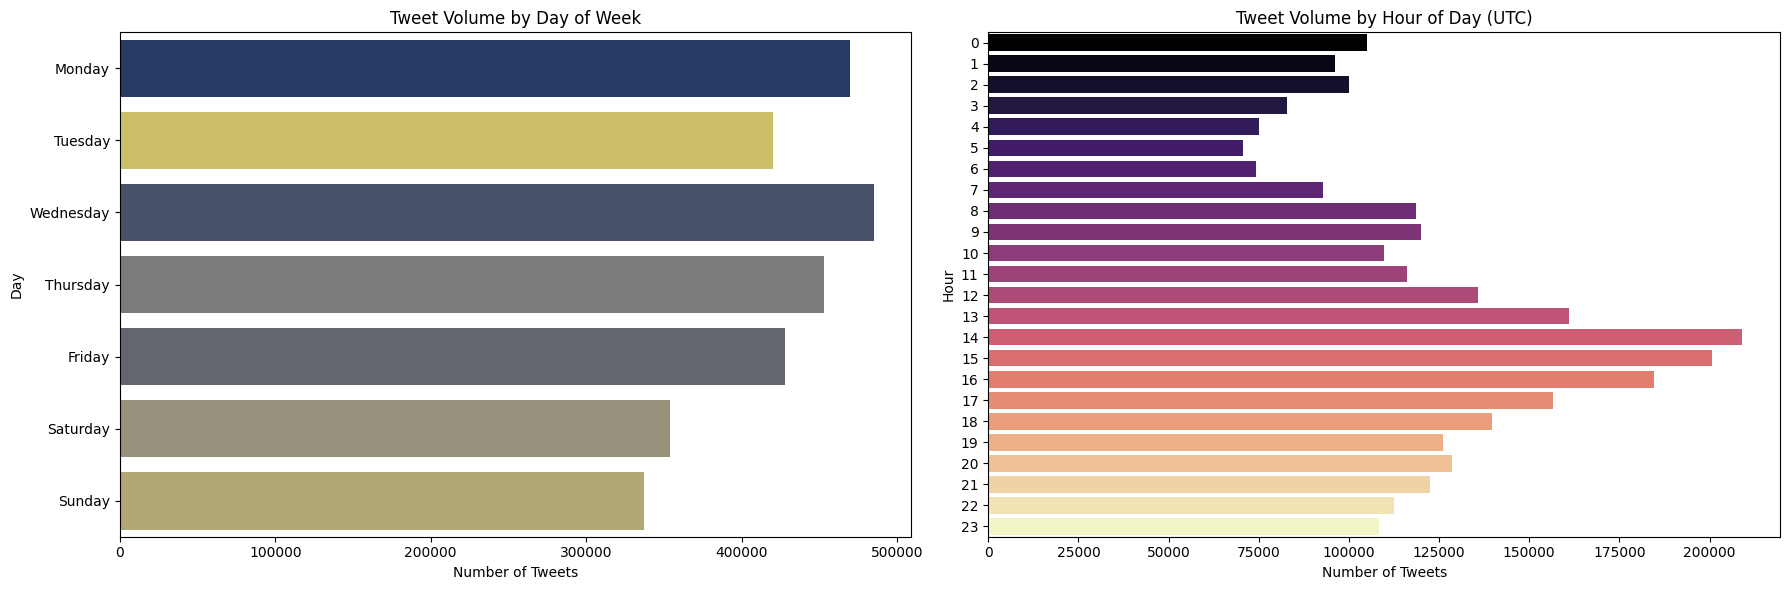

In [18]:
# Activity Patterns by Day and Hour
df['day_of_week'] = df['publish_date'].dt.day_name()
df['hour_of_day'] = df['publish_date'].dt.hour
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Day of Week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(y='day_of_week', hue='day_of_week', data=df, order=day_order, palette='cividis', ax=axes[0], legend=False)
axes[0].set_title('Tweet Volume by Day of Week')
axes[0].set_xlabel('Number of Tweets')
axes[0].set_ylabel('Day')
# Hour of Day
sns.countplot(y='hour_of_day', hue='hour_of_day', data=df, palette='magma', ax=axes[1], legend=False)
axes[1].set_title('Tweet Volume by Hour of Day (UTC)')
axes[1].set_xlabel('Number of Tweets')
axes[1].set_ylabel('Hour')
plt.tight_layout()
plt.show()


### Retweet Analysis
This cell extracts the original authors from retweets since the dataset only contains bots. this is needed for the next section

In [ ]:

#Extract 'original_author' for the Amplifier analysis
df['original_author'] = df['content'].str.extract(r'RT @(\w+):')


### The Workhorses
This cell identifies and visualizes the top 10 most active accounts based on tweet volume.

author
EXQUOTE            59174
SCREAMYMONKEY      44001
AMELIEBALDWIN      35261
WORLDNEWSPOLI      35155
TODAYPITTSBURGH    33602
SPECIALAFFAIR      32556
SEATTLE_POST       30793
FINDDIET           29038
KANSASDAILYNEWS    28806
ROOMOFRUMOR        28351
Name: count, dtype: int64


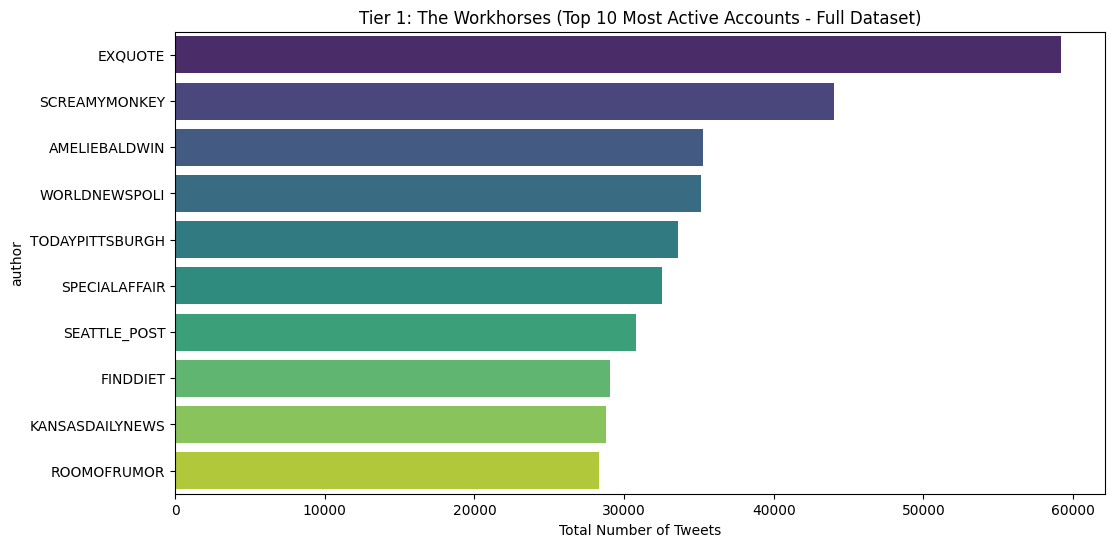

In [21]:
# 1. Identify Top 10 most active authors
top_workhorses = df['author'].value_counts().head(10)

print(top_workhorses)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_workhorses.values, y=top_workhorses.index, palette='viridis', hue=top_workhorses.index, legend=False)
plt.title('Tier 1: The Workhorses (Top 10 Most Active Accounts - Full Dataset)')
plt.xlabel('Total Number of Tweets')
plt.show()

### The Broadcasters
This cell identifies and visualizes the top 10 accounts with the highest follower counts

author
NOVOSTIMSK        251276
TEN_GOP           145244
NOVOSTISPB        113638
KADIROVRUSSIA     110155
MAXDEMENTIEV      103197
LAVROVMUESLI       72720
JENN_ABRAMS        71022
PAMELA_MOORE13     70734
TODAYNYCITY        62088
ELEVEN_GOP         59100
Name: followers, dtype: int64


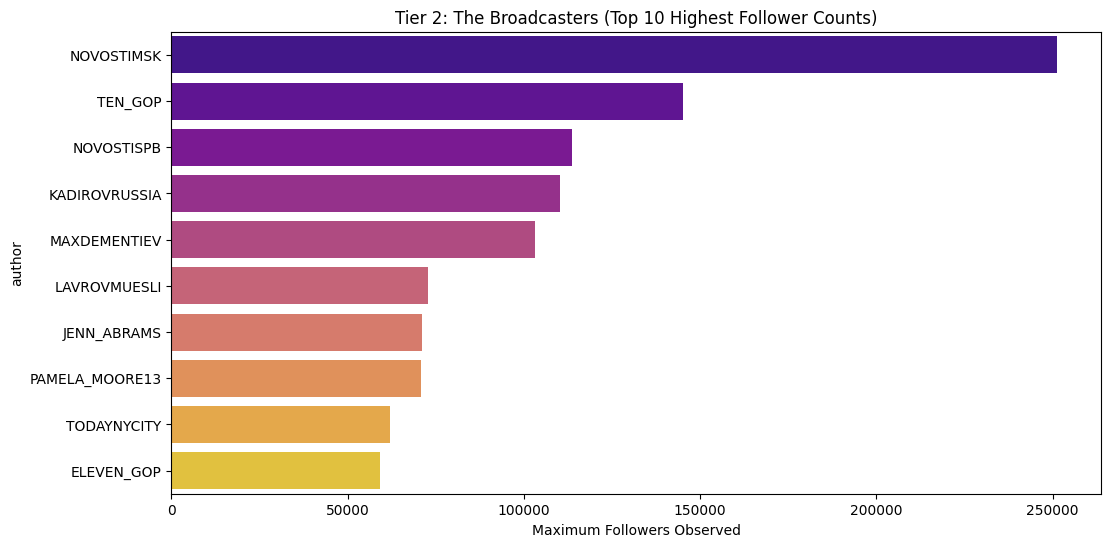

In [22]:
# 1. Identify Top 10 authors by max followers
# We use max() because follower counts fluctuate over time
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(10)

print(top_broadcasters)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_broadcasters.values, y=top_broadcasters.index, palette='plasma', hue=top_broadcasters.index, legend=False)
plt.title('Tier 2: The Broadcasters (Top 10 Highest Follower Counts)')
plt.xlabel('Maximum Followers Observed')
plt.show()

### The Amplifiers
This cell identifies and visualizes the external accounts that were most frequently retweeted by the dataset

original_author
jstines3           254
2AFight            216
Shooters_Wife      208
dansch2002         146
gerfingerpoken     137
Network_Citizen    126
Fingersflying      108
mitchellvii         91
Stonewall_77        84
beny_benson         74
Name: count, dtype: int64


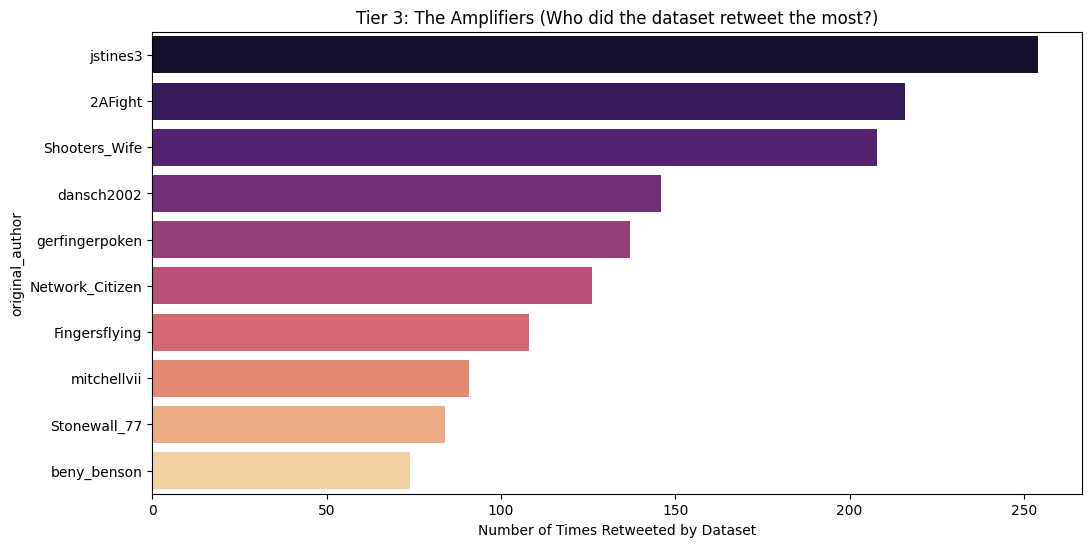

In [23]:
# 1. Identify Top 10 most retweeted handles
# We drop N/A values to focus only on actual retweets
top_amplifiers = df['original_author'].value_counts().head(10)

print(top_amplifiers)

# 2. Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=top_amplifiers.values, y=top_amplifiers.index, palette='magma', hue=top_amplifiers.index, legend=False)
plt.title('Tier 3: The Amplifiers (Who did the dataset retweet the most?)')
plt.xlabel('Number of Times Retweeted by Dataset')
plt.show()

### Time distribution by account type
This cell displays the distribution of accounts by type over time, with the full distribution displayed in the background

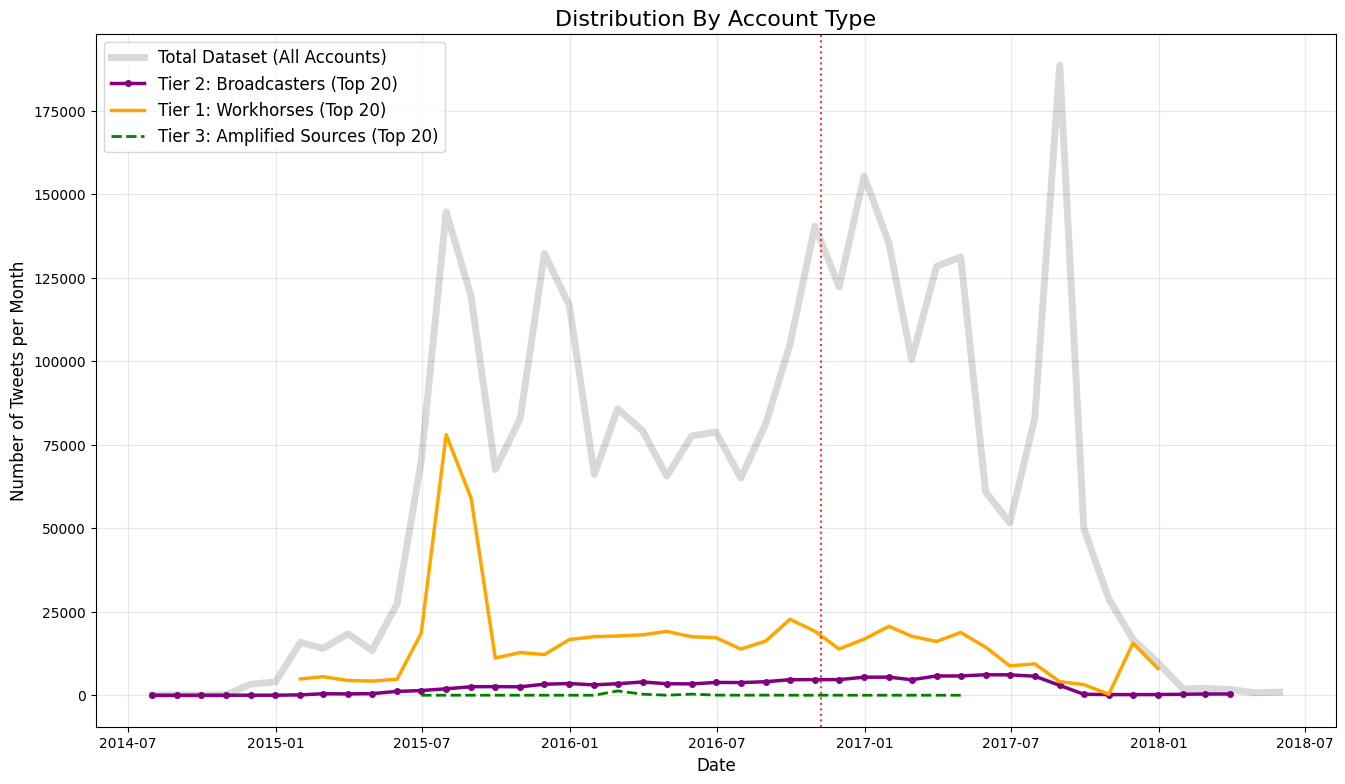

In [33]:
# Group A: The WORKHORSES (High Volume)
top_workhorses = df['author'].value_counts().head(20).index

# Group B: The BROADCASTERS (High Reach/Followers)
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(20).index

# Group C: The AMPLIFIED (The content sources)
top_amplified = df['original_author'].value_counts().head(20).index

# Create Time Series for each group (Resampled by Month)
ts_total = df.set_index('publish_date').resample('ME').size()
ts_workhorse = df[df['author'].isin(top_workhorses)].set_index('publish_date').resample('ME').size()
ts_broadcaster = df[df['author'].isin(top_broadcasters)].set_index('publish_date').resample('ME').size()
ts_amplified = df[df['original_author'].isin(top_amplified)].set_index('publish_date').resample('ME').size()

# Filter Date Range
start_date = '2014-07-01'  # Mid-2014

# Apply the date filter strictly
ts_total = ts_total[ts_total.index >= start_date]
ts_workhorse = ts_workhorse[ts_workhorse.index >= start_date]
ts_broadcaster = ts_broadcaster[ts_broadcaster.index >= start_date]
ts_amplified = ts_amplified[ts_amplified.index >= start_date]

# Plotting the Raw Volumes
plt.figure(figsize=(16, 9))

# Plot Total (The General Noise)
plt.plot(ts_total.index, ts_total,
         color='black', alpha=0.15, linewidth=5, label='Total Dataset (All Accounts)')

# Plot The 3 Tiers
plt.plot(ts_broadcaster.index, ts_broadcaster,
         color='purple', linewidth=2.5, linestyle='-', marker='o', markersize=4, label='Tier 2: Broadcasters (Top 20)')

plt.plot(ts_workhorse.index, ts_workhorse,
         color='orange', linewidth=2.5, linestyle='-', label='Tier 1: Workhorses (Top 20)')

plt.plot(ts_amplified.index, ts_amplified,
         color='green', linewidth=2, linestyle='--', label='Tier 3: Amplified Sources (Top 20)')

plt.title('Distribution By Account Type', fontsize=16)
plt.ylabel('Number of Tweets per Month', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight 2016 Election
plt.axvline(pd.to_datetime('2016-11-08'), color='red', linestyle=':', alpha=0.8, label='2016 Election')

plt.show()

### Time distribution by account type (normalised)
This cell displays the normalised distribution of accounts by type over time, with the full distribution displayed in the background

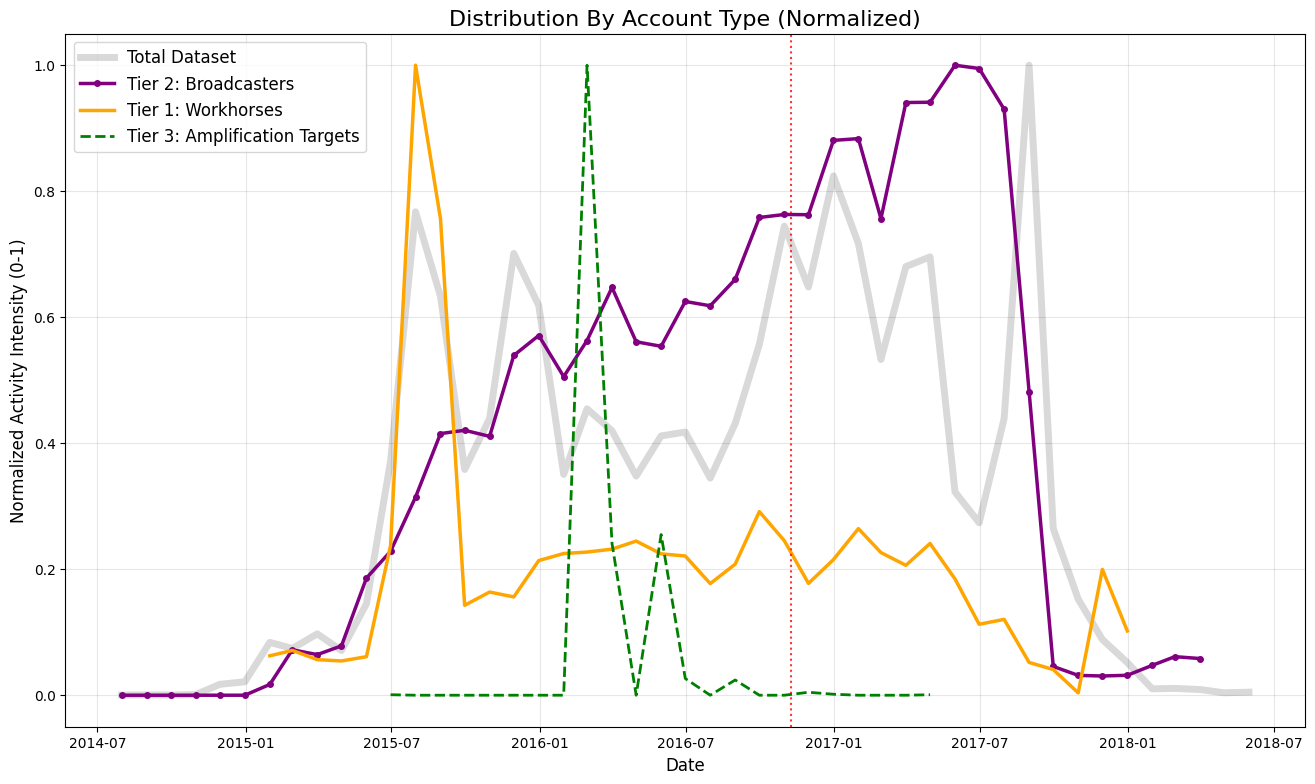

In [34]:
#Define the 3 Distinct Groups
# Group A: The WORKHORSES (High Volume)
top_workhorses = df['author'].value_counts().head(20).index

# Group B: The BROADCASTERS (High Reach/Followers)
top_broadcasters = df.groupby('author')['followers'].max().sort_values(ascending=False).head(20).index

# Group C: The AMPLIFIED (The content sources)
top_amplified = df['original_author'].value_counts().head(20).index

#Create Time Series for each group (Resampled by Month)
ts_total = df.set_index('publish_date').resample('ME').size()
ts_workhorse = df[df['author'].isin(top_workhorses)].set_index('publish_date').resample('ME').size()
ts_broadcaster = df[df['author'].isin(top_broadcasters)].set_index('publish_date').resample('ME').size()
ts_amplified = df[df['original_author'].isin(top_amplified)].set_index('publish_date').resample('ME').size()


# 4. Filter Date Range & Normalize
start_date = '2014-07-01'  # Mid-2014

# Helper function to filter and normalize
def filter_and_normalize(ts, start_date):
    # Filter by date
    ts_subset = ts[ts.index >= start_date]
    # Normalize to 0-1 scale so we can compare trends, not just volume
    return ts_subset / ts_subset.max()

# Apply the filter/normalization
ts_total = filter_and_normalize(ts_total, start_date)
ts_workhorse = filter_and_normalize(ts_workhorse, start_date)
ts_broadcaster = filter_and_normalize(ts_broadcaster, start_date)
ts_amplified = filter_and_normalize(ts_amplified, start_date)
# --- MODIFICATION END ---

# 5. Plotting the "Lead/Follow" Dynamics
plt.figure(figsize=(16, 9))

# Plot Total (The General Noise)
plt.plot(ts_total.index, ts_total,
         color='black', alpha=0.15, linewidth=5, label='Total Dataset')

# Plot The 3 Tiers
plt.plot(ts_broadcaster.index, ts_broadcaster,
         color='purple', linewidth=2.5, linestyle='-', marker='o', markersize=4, label='Tier 2: Broadcasters')

plt.plot(ts_workhorse.index, ts_workhorse,
         color='orange', linewidth=2.5, linestyle='-', label='Tier 1: Workhorses')

plt.plot(ts_amplified.index, ts_amplified,
         color='green', linewidth=2, linestyle='--', label='Tier 3: Amplification Targets')

plt.title('Distribution By Account Type (Normalized)', fontsize=16)
plt.ylabel('Normalized Activity Intensity (0-1)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight 2016 Election
plt.axvline(pd.to_datetime('2016-11-08'), color='red', linestyle=':', alpha=0.8, label='2016 Election')

plt.show()

### Subset Analysis
This cell creates a focused subset of the data, filtering for English-language tweets from LeftTroll and RightTroll accounts.

In [11]:
import pandas as pd
import re


# 1. Define filter criteria
target_categories = ['LeftTroll', 'RightTroll']
target_language = 'English'
start_date = '2014-09-01'

# 2. Create the subset
# Filter first to optimize performance
df_subset = df[
    (df['language'] == target_language) &
    (df['account_category'].isin(target_categories)) &
    (df['publish_date'] >= start_date)
].copy()

# 3. Feature Engineering (Creating the columns you requested)
# Extract original author from Retweets
df_subset['original_author'] = df_subset['content'].str.extract(r'RT @(\w+):')
# Extract mentions
df_subset['mentions'] = df_subset['content'].apply(lambda x: re.findall(r'@(\w+)', str(x)))
# publish_date is already datetime from the initial conversion

# 4. Select specific columns
columns_to_keep = [
    'tweet_id',
    'author',
    'content',
    'publish_date',
    'language',
    'followers',
    'following',
    'updates',
    'post_type',
    'retweet',
    'account_category',
    'original_author',
    'mentions'
]

# Keep only existing columns from the list
existing_cols = [c for c in columns_to_keep if c in df_subset.columns]
df_subset = df_subset[existing_cols]

# 5. Inspection
print(f"Original Dataset Size: {len(df)}")
print(f"Subset Size (English + Left/Right Trolls + from Sep 2014): {len(df_subset)}")
print(f"Data retained: {len(df_subset)/len(df)*100:.2f}%")
print("\nClass Balance in Subset:")
print(df_subset['account_category'].value_counts())

Original Dataset Size: 2946207
Subset Size (English + Left/Right Trolls + from Sep 2014): 1126956
Data retained: 38.25%

Class Balance in Subset:
account_category
RightTroll    704953
LeftTroll     422003
Name: count, dtype: int64


### Hashtags Left vs Right Trolls
This cell shows the most frequently used hashtags by left and right trolls

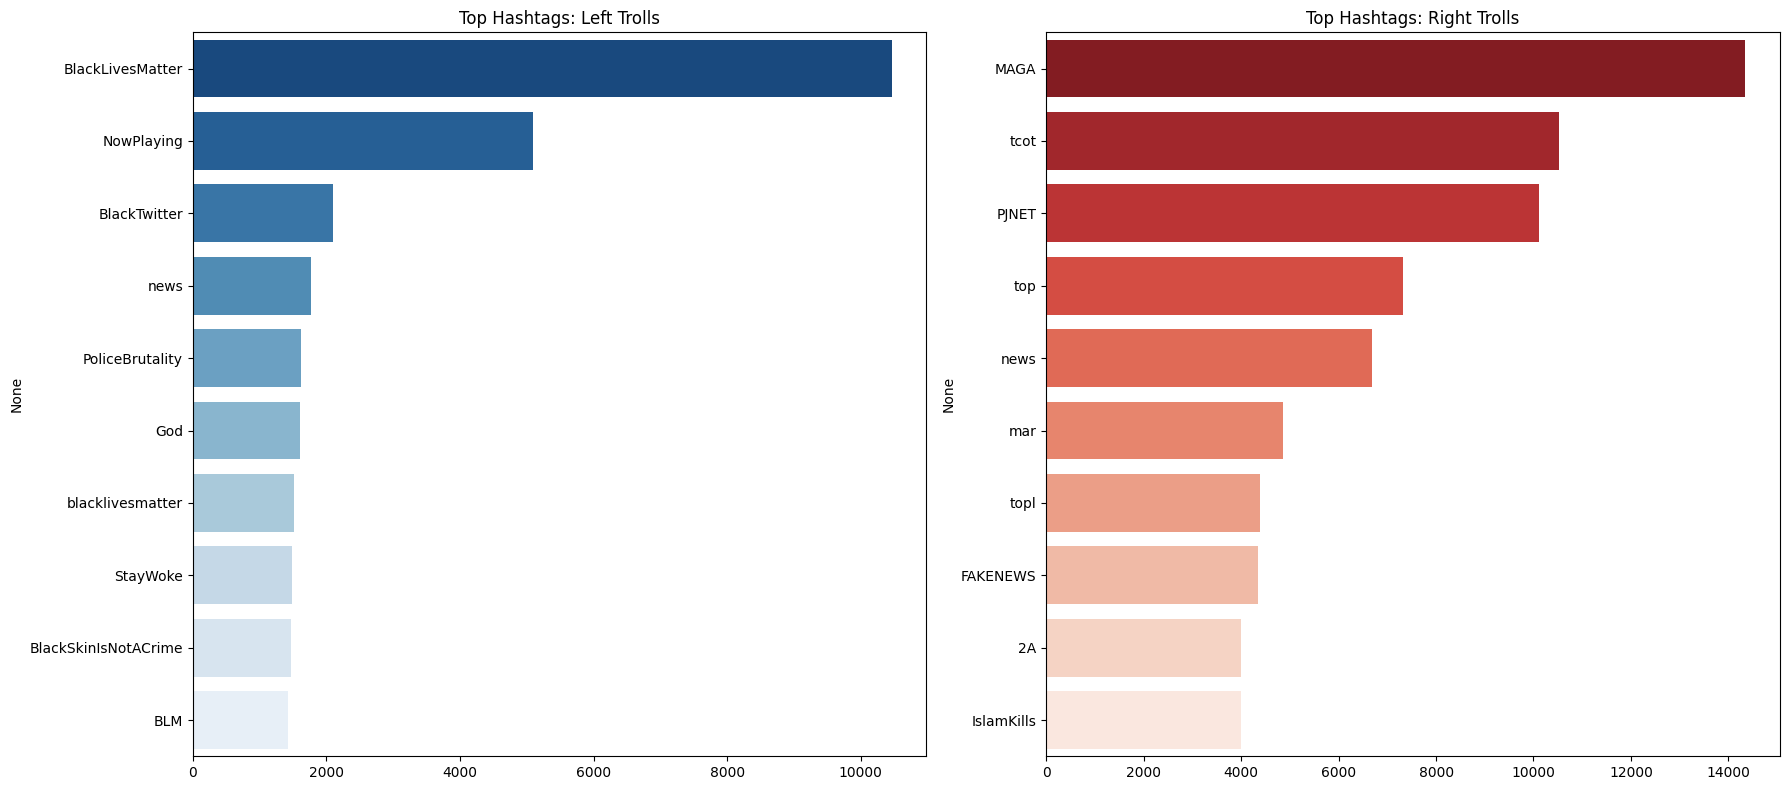

In [35]:
# Function to get top hashtags for a specific dataframe
def get_top_tags(data, n=10):
    text_blob = " ".join(data.dropna().astype(str))
    tags = re.findall(r"#(\w+)", text_blob)
    return pd.Series(Counter(tags)).sort_values(ascending=False).head(n)

# Get top tags for Left and Right separately
left_tags = get_top_tags(df_subset[df_subset['account_category'] == 'LeftTroll']['content'])
right_tags = get_top_tags(df_subset[df_subset['account_category'] == 'RightTroll']['content'])

# Plotting side-by-side
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(x=left_tags.values, y=left_tags.index, ax=ax[0], palette='Blues_r', hue=left_tags.index, legend=False)
ax[0].set_title('Top Hashtags: Left Trolls')

sns.barplot(x=right_tags.values, y=right_tags.index, ax=ax[1], palette='Reds_r', hue=right_tags.index, legend=False)
ax[1].set_title('Top Hashtags: Right Trolls')

plt.tight_layout()
plt.show()

### Word Frequency Analysis
This cell analyses the frequency of words used by both left and right trolls.

Analyzing Left Troll vocabulary...
Analyzing Right Troll vocabulary...


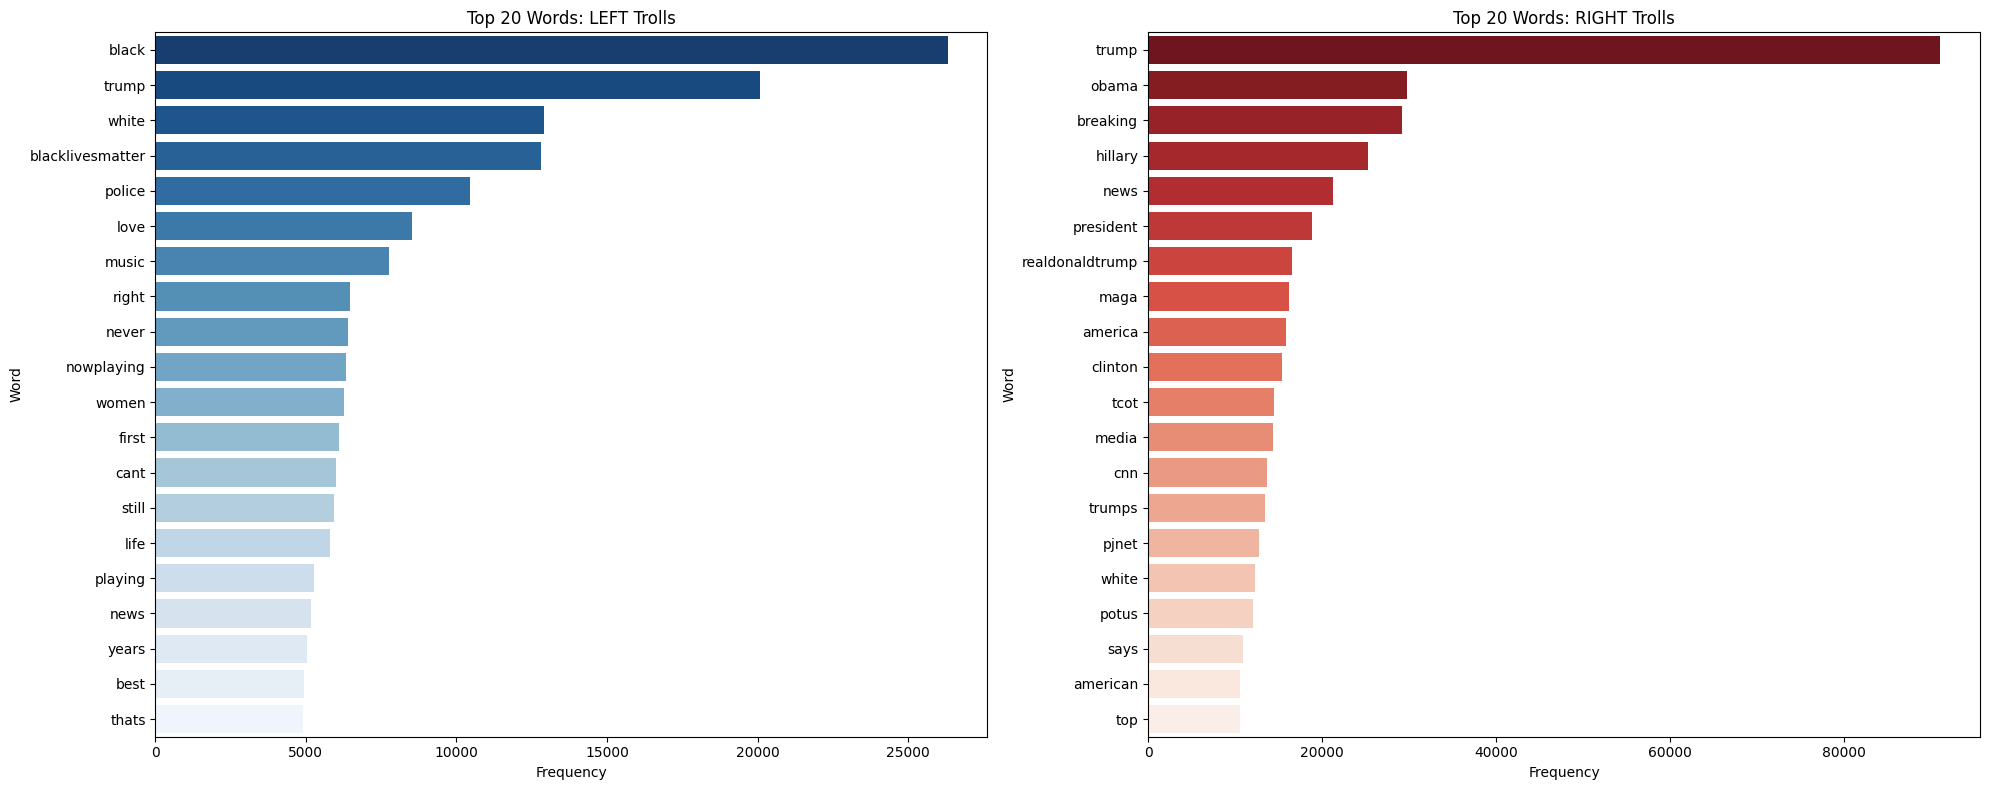

In [36]:
# 1. Setup Stopwords

try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
custom_ignore_list = [
    'https', 'http', 'rt', 'co', 'amp', 'bit', 'ly', 'via', 'ifttt',
    'just', 'like', 'will', 'one', 'get', 'new', 'people', 'time',
    'would', 'make', 'video', 'know', 'say', 'see', 'can', 'got',
    'want', 'back', 'good', 'day', 'year', 'think', 'need', 'look',
    'man', 'woman', 'us', 'go', 'much', 'thing', 'really', 'today',
    'twitter', 'com', 'pic', 'status', 'web', 'instagram', 'fb','dont'
]
# Add common tweet-specific noise to stopwords
stop_words.update(custom_ignore_list)

# 2. Define Helper Function to Clean and Count
def get_top_words(text_series, n=20):
    all_words = []
    # Convert to list for faster processing than iterating series
    for text in text_series.dropna().tolist():
        # Lowercase
        text = str(text).lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation/numbers (keep only letters)
        text = re.sub(r'[^a-z\s]', '', text)

        # Tokenize and filter
        # Words must be > 2 chars and not in stop_words
        words = [w for w in text.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)

    return pd.DataFrame(Counter(all_words).most_common(n), columns=['Word', 'Count'])

# 3. Process the Data
print("Analyzing Left Troll vocabulary...")
left_words_df = get_top_words(df_subset[df_subset['account_category'] == 'LeftTroll']['content'])

print("Analyzing Right Troll vocabulary...")
right_words_df = get_top_words(df_subset[df_subset['account_category'] == 'RightTroll']['content'])

# 4. Visualize Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left Trolls Plot
sns.barplot(data=left_words_df, x='Count', y='Word', ax=axes[0], palette='Blues_r', hue='Word', legend=False)
axes[0].set_title('Top 20 Words: LEFT Trolls')
axes[0].set_xlabel('Frequency')

# Right Trolls Plot
sns.barplot(data=right_words_df, x='Count', y='Word', ax=axes[1], palette='Reds_r', hue='Word', legend=False)
axes[1].set_title('Top 20 Words: RIGHT Trolls')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

### LeftTroll vs RightTroll Monthly Analysis
This interactive graph shows the monthly distribution of tweets per for LeftTroll and RightTroll accounts.

In [ ]:
import plotly.express as px

# Set index
time_subset = df_subset.set_index('publish_date').sort_index()

# Resample by Month and Account Category to compare activity
# We use unstack() to create columns for LeftTroll and RightTroll
monthly_comparison = time_subset.groupby([pd.Grouper(freq='ME'), 'account_category']).size().unstack()

# Plotting using Plotly for interactivity
fig = px.line(monthly_comparison, x=monthly_comparison.index, y=monthly_comparison.columns,
              title='Monthly Tweet Volume: Left Trolls vs. Right Trolls',
              labels={'value':'Number of Tweets', 'publish_date':'Date', 'variable':'Account Category'})

# Add Reference Lines for 2016 Election (Plotly equivalent)
# Removing annotation_text and annotation_position to bypass TypeError, as the line itself is the primary goal and hover provides details.
fig.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig.update_layout(hovermode="x unified") # Unified hover for better comparison
fig.show()

### LeftTroll vs RightTroll Daily Analysis
This interactive graph shows the daily distribution of tweets for LeftTroll and RightTroll accounts.

In [ ]:
# Set index
time_subset = df_subset.set_index('publish_date').sort_index()

# Resample by Day and Account Category to compare activity
# We use unstack() to create columns for LeftTroll and RightTroll
monthly_comparison = time_subset.groupby([pd.Grouper(freq='D'), 'account_category']).size().unstack()

# Calculate max y-value for padding the y-axis range
max_y_value = monthly_comparison.max().max() if not monthly_comparison.empty else 0
y_axis_upper_bound = max_y_value * 1.05 # Add 5% padding

# Plotting using Plotly for interactivity
fig = px.line(monthly_comparison, x=monthly_comparison.index, y=monthly_comparison.columns,
              title='Daily Tweet Volume: Left Trolls vs. Right Trolls', # Changed title for 'D' freq
              labels={'value':'Number of Tweets', 'publish_date':'Date', 'variable':'Account Category'})

# Add Reference Lines for 2016 Election (Plotly equivalent)
# Removing annotation_text and annotation_position to bypass TypeError, as the line itself is the primary goal and hover provides details.
fig.add_vline(x=pd.to_datetime('2016-11-08').isoformat(), line_dash="dash", line_color="red")

fig.update_layout(hovermode="x unified", yaxis_range=[0, y_axis_upper_bound]) # Add yaxis_range to ensure full visibility
fig.show()

### Word Frequency During Tweet Peaks
This cell looks for the most used words during the peaks of the left and right tweets.

Right Troll peak records: 74899
Left Troll peak records: 13158

Analyzing Left Troll vocabulary (peak day)...
Analyzing Right Troll vocabulary (peak period)...


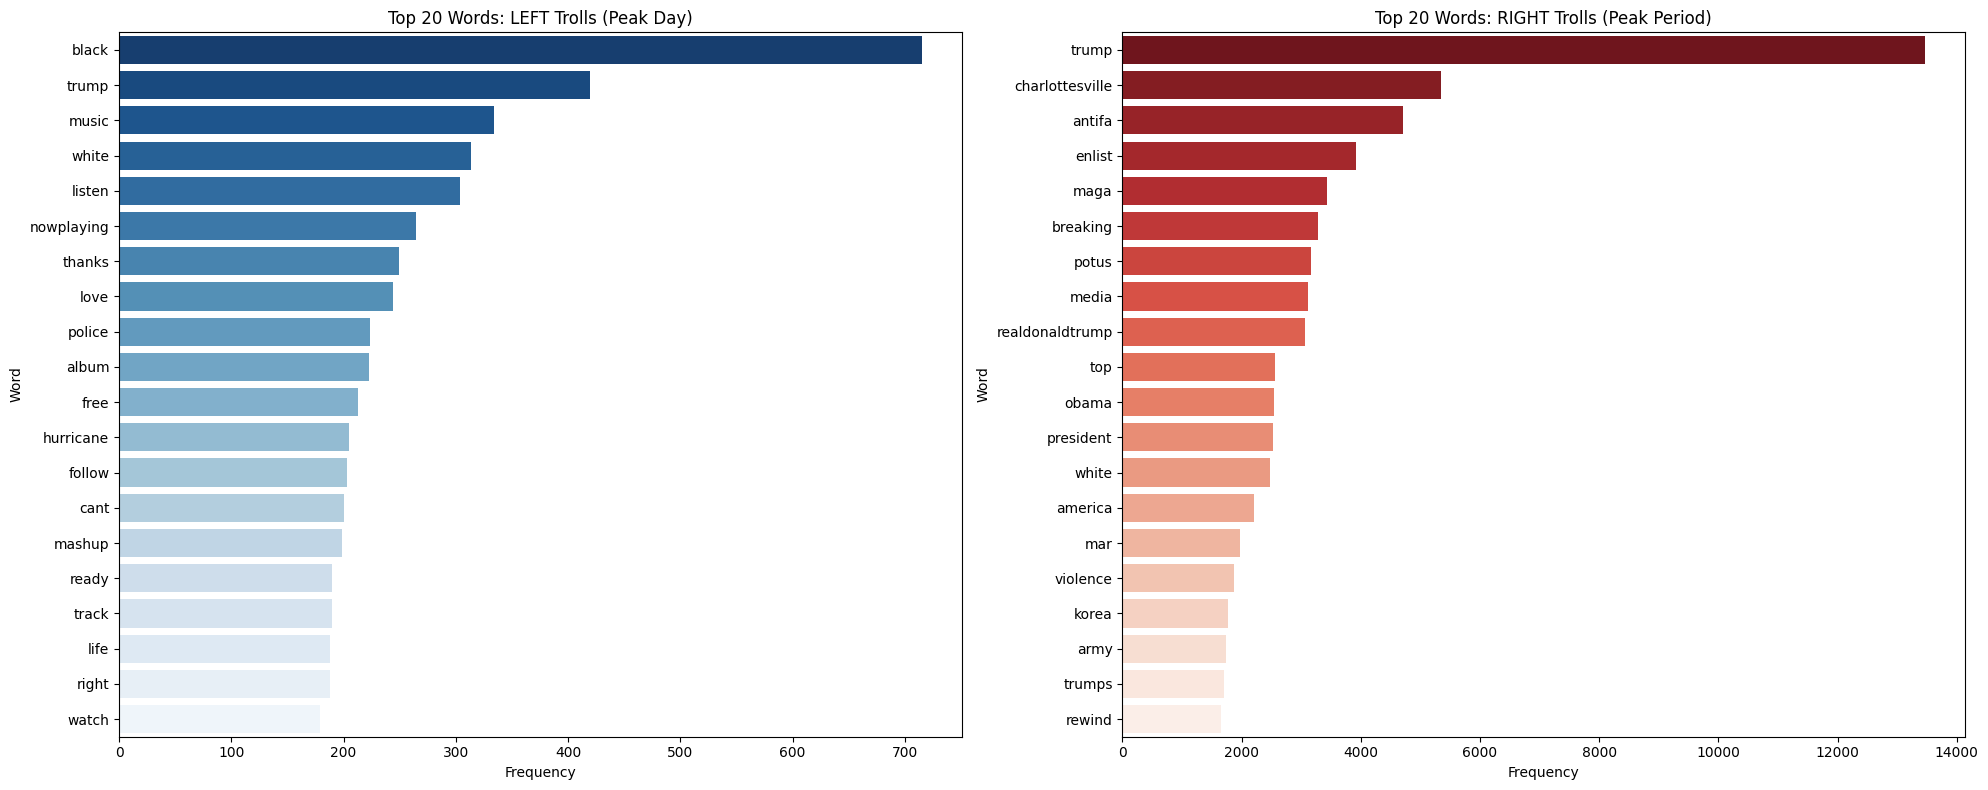

In [ ]:
#import libraries needed for word analysis 
import nltk
from nltk.corpus import stopwords
from collections import Counter
# get a list of stop words to ensure that we don't include common words in the analysis
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

custom_ignore_list = [
    'https', 'http', 'rt', 'co', 'amp', 'bit', 'ly', 'via', 'ifttt',
    'just', 'like', 'will', 'one', 'get', 'new', 'people', 'time',
    'would', 'make', 'video', 'know', 'say', 'see', 'can', 'got',
    'want', 'back', 'good', 'day', 'year', 'think', 'need', 'look',
    'man', 'woman', 'us', 'go', 'much', 'thing', 'really', 'today',
    'twitter', 'com', 'pic', 'status', 'web', 'instagram', 'fb', 'dont'
]

stop_words.update(custom_ignore_list)

# -------------------------------------------------------------
# 2. Helper Function
# -------------------------------------------------------------
def get_top_words(text_series, n=20):
    all_words = []
    for text in text_series.dropna().tolist():
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
        words = [w for w in text.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['Word', 'Count'])

# -------------------------------------------------------------
# 3. Filter by Peak Windows
# -------------------------------------------------------------

# Right Troll Peak: 2017-08-11 to 2017-08-18
right_peak = df_subset[
    (df_subset['account_category'] == 'RightTroll') &
    (df_subset['publish_date'] >= '2017-08-11') &
    (df_subset['publish_date'] <= '2017-08-18')
]

# Left Troll Peak: 2016-10-06 (feel free to extend +-1 day)
left_peak = df_subset[
    (df_subset['account_category'] == 'LeftTroll') &
    (df_subset['publish_date'] >= '2016-10-5') &
    (df_subset['publish_date'] <= '2016-10-7')
]

print(f"Right Troll peak records: {len(right_peak)}")
print(f"Left Troll peak records: {len(left_peak)}\n")

# -------------------------------------------------------------
# 4. Generate Top Words
# -------------------------------------------------------------
print("Analyzing Left Troll vocabulary (peak day)...")
left_words_df = get_top_words(left_peak['content'])

print("Analyzing Right Troll vocabulary (peak period)...")
right_words_df = get_top_words(right_peak['content'])

# -------------------------------------------------------------
# 5. Visualize Side-by-Side
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(data=left_words_df, x='Count', y='Word', ax=axes[0], palette='Blues_r', hue='Word', legend=False)
axes[0].set_title('Top 20 Words: LEFT Trolls (Peak Day)')
axes[0].set_xlabel('Frequency')

sns.barplot(data=right_words_df, x='Count', y='Word', ax=axes[1], palette='Reds_r', hue='Word', legend=False)
axes[1].set_title('Top 20 Words: RIGHT Trolls (Peak Period)')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()
